In [3]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.parallel import DataParallel
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, T5Config, T5ForConditionalGeneration
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import nltk
# nltk.download('punkt')
# 类

class GPT2Dataset(Dataset):

  def __init__(self, propmt_list, answer_list, tokenizer,
               max_length_propmt=1024, max_length_answer=10):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []
    self.answer_ids = []

    # 设置填充参数为右填充
    tokenizer.padding_side = "right"

    for txt in propmt_list:

      encodings_dict = tokenizer('<s>'+ txt , truncation=True, max_length=max_length_propmt, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
    for ans in answer_list:

      encodings_dict = tokenizer('<s>'+ str(ans), truncation=True, max_length=max_length_answer, padding="max_length")

      self.answer_ids.append(torch.tensor(encodings_dict['input_ids']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx], self.answer_ids[idx]
  

In [5]:
def model_training(config_path, model_path, tokenizer, train_dataloader,
                   validation_dataloader,epochs,learning_rate,warmup_ratio,
                   epsilon):
    # I'm not really doing anything with the config buheret
    configuration = T5Config.from_pretrained(config_path, output_hidden_states=False)

    # instantiate the model
    model = T5ForConditionalGeneration.from_pretrained(model_path, config=configuration)

    # this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
    # otherwise the tokenizer and model tensors won't match up
    model.resize_token_embeddings(len(tokenizer))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    if torch.cuda.device_count() > 1:
        
        #NIKA added this bit for tracking;
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        # Wrap the model with DataParallel to use both GPUs
        model = DataParallel(model)
        #NIKA added above bit for tracking;
    
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    # some parameters I cooked up that work reasonably well

    epochs = epochs
    learning_rate = learning_rate
    warmup_steps = int(len(train_dataloader) * epochs * warmup_ratio)
    epsilon = epsilon

    # this produces sample output every 100 steps
    sample_every = 1000

    # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
    optimizer = AdamW(model.parameters(),
                    lr = learning_rate,
                    eps = epsilon
                    )

    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    # This changes the learning rate as the training loop progresses
    # scheduler = get_linear_schedule_with_warmup(optimizer, 
    #                                             num_warmup_steps = warmup_steps, 
    #                                             num_training_steps = total_steps)

    scheduler = get_cosine_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    
    def format_time(elapsed):
        return str(datetime.timedelta(seconds=int(round((elapsed)))))

    total_t0 = time.time()

    training_stats = []

    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()

        total_train_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):

            b_input_ids = batch[0].to(device)
            b_labels = batch[2].to(device)
            b_masks = batch[1].to(device)

            model.zero_grad()        

            outputs = model(  b_input_ids,
                            labels=b_labels, 
                            attention_mask = b_masks,
                            output_attentions=True
                            )

            loss = outputs[0]  
            loss = loss.mean()  # 获取所有GPU上的平均损失


            batch_loss = loss.item()
            total_train_loss += batch_loss

            # Get sample every x batches.
            if step % sample_every == 0 and not step == 0:

                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))
                
                model.train()

            loss.backward()

            optimizer.step()

            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader) 
        writer.add_scalar("Loss/train", avg_train_loss, epoch_i+1)      
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        print("")
        print("Running Validation...")

        t0 = time.time()

        model.eval()

        total_eval_loss = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            b_input_ids = batch[0].to(device)
            b_labels = batch[2].to(device)
            b_masks = batch[1].to(device)
            
            with torch.no_grad():        
                outputs  = model(b_input_ids, 
    #                            token_type_ids=None, 
                                attention_mask = b_masks,
                                labels=b_labels,
                                output_attentions=True)
            
                loss = outputs[0]  
                loss = loss.mean()  # 获取所有GPU上的平均损失
            batch_loss = loss.item()
            total_eval_loss += batch_loss        

        avg_val_loss = total_eval_loss / len(validation_dataloader)
        writer.add_scalar("Loss/test", avg_val_loss, epoch_i+1)
        
        validation_time = format_time(time.time() - t0)    

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    return model, tokenizer, training_stats

/var/folders/hn/yy0f4gf550d1fb7rsdb9wszm0000gp/T/ipykernel_38201/2329879666.py:41: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

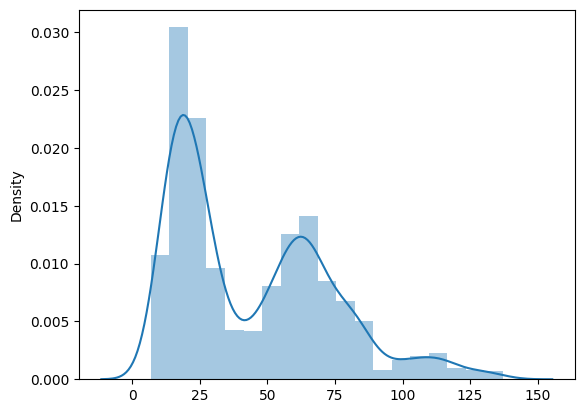

In [8]:
token_path = 'seyonec/PubChem10M_SMILES_BPE_450k'
path = 'GT4SD/multitask-text-and-chemistry-t5-base-standard'

tokenizer = AutoTokenizer.from_pretrained(token_path, bos_token='<s>', eos_token='</s>', pad_token='[PAD]', padding_side='right') 
# print("The max model length is {} for this model.".format(tokenizer.model_max_length))
# print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
# print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
# print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))
custom_tokens = [
    'Predict the atomization energy of the following SMILES:',
    'Predict the bandgap crystal of the following SMILES:',
    'Predict the Tg of the following SMILES:',
    'Predict the heat resistance class of the following SMILES:'
]
tokenizer.add_tokens(custom_tokens)

# df_train = pd.read_csv('/work/PolyGPT/T5/0data&code/data/train/prompt-target.csv')
df_train = pd.read_csv('../data/train/prompt-target.csv') #i have changed directory to mine
df_train.dropna(inplace=True) #remove NA values
prompt_list_train = df_train['prompt'].tolist() #just use the main bio text in this example
answer_list_train = df_train['target'].tolist() #just use the main bio text in this example

#df_test = pd.read_csv('/work/PolyGPT/T5/0data&code/data/test/prompt-target.csv')
df_test = pd.read_csv('../data/test/prompt-target.csv') #i have changed directory to mine
df_test.dropna(inplace=True) #remove NA values
prompt_list_test = df_test['prompt'].tolist() #just use the main bio text in this example
answer_list_test = df_test['target'].tolist() #just use the main bio text in this example

doc_lengths = []

for prompt in prompt_list_test:

    # get rough token count distribution
    # tokens = nltk.word_tokenize(bio)
    tokens = tokenizer.encode(prompt)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [10]:
## fine tune on properties datasets
batch_size = 120

train_dataset = GPT2Dataset(prompt_list_train, answer_list_train, tokenizer,
               max_length_propmt=150, max_length_answer=6)
val_dataset = GPT2Dataset(prompt_list_test, answer_list_test, tokenizer,
               max_length_propmt=150, max_length_answer=6)


print('{:>5,} training samples'.format(len(prompt_list_train)))
print('{:>5,} validation samples'.format(len(prompt_list_test)))


# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
config_path = path
model_path = path

epochs = 100
learning_rate = 5e-6
warmup_ratio = 0.2
epsilon = 1e-8

model, tokenizer, training_stats = model_training(config_path, model_path, tokenizer,
                                                   train_dataloader,validation_dataloader,
                                                   epochs,learning_rate,warmup_ratio,
                                                    epsilon)

KeyboardInterrupt: 

In [ ]:
output_dir = '/work/PolyGPT/T5/model_save/cls-5tasks-bs150-bs8-lr5e6-epoch100'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to /work/PolyGPT/T5/model_save/cls-T5-bs150-bs8-lr5e6-epoch100


('/work/PolyGPT/T5/model_save/cls-T5-bs150-bs8-lr5e6-epoch100/tokenizer_config.json',
 '/work/PolyGPT/T5/model_save/cls-T5-bs150-bs8-lr5e6-epoch100/special_tokens_map.json',
 '/work/PolyGPT/T5/model_save/cls-T5-bs150-bs8-lr5e6-epoch100/spiece.model',
 '/work/PolyGPT/T5/model_save/cls-T5-bs150-bs8-lr5e6-epoch100/added_tokens.json',
 '/work/PolyGPT/T5/model_save/cls-T5-bs150-bs8-lr5e6-epoch100/tokenizer.json')

In [6]:

# prompt = '[CLS]' + "[*]NC(=O)OC(C=C1)=CC=C1[*]'s band gap chain is"

# prompt = "N1(CCCCCCCCN2C(=O)c3cccc(*)c3C2=O)C(=O)c2c(c(Oc3ccc(Oc4ccc(O*)cc4)cc3)ccc2)C1=O"
prompt = 'Predict the heat resistance class of the following SMILES: O=c1n(C)c(=O)c2cc3c(=O)n(-c4ccc(-c5ccc(C)cc5)cc4)c(=O)c3cc21'

generated = tokenizer.encode(prompt)
print(generated)
tokens = tokenizer.convert_ids_to_tokens(generated)
print(tokens)

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generated = generated.to(device)

sample_outputs = model.module.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=False,   
                                top_k=100, 
                                max_length = 8,
                                top_p=0.99, 
                                num_return_sequences=1
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i+1, tokenizer.decode(sample_output, skip_special_tokens=False)))

[32112, 411, 2423, 75, 536, 29, 599, 254, 61, 75, 599, 2423, 667, 61, 75, 357, 75, 75, 519, 75, 599, 2423, 667, 61, 29, 599, 18, 75, 591, 75, 75, 75, 599, 18, 75, 755, 75, 75, 75, 599, 254, 61, 75, 75, 9120, 75, 75, 7256, 75, 599, 2423, 667, 61, 75, 519, 75, 75, 2658, 1]
['Predict the heat resistance class of the following SMILES:', '▁O', '=', 'c', '1', 'n', '(', 'C', ')', 'c', '(', '=', 'O', ')', 'c', '2', 'c', 'c', '3', 'c', '(', '=', 'O', ')', 'n', '(', '-', 'c', '4', 'c', 'c', 'c', '(', '-', 'c', '5', 'c', 'c', 'c', '(', 'C', ')', 'c', 'c', '5)', 'c', 'c', '4)', 'c', '(', '=', 'O', ')', 'c', '3', 'c', 'c', '21', '</s>']
1: <pad><s> class 1</s>


